In [2]:
import pandas as pd

raw_df = pd.read_csv('users_orders(in).csv', engine='pyarrow')

df = raw_df.copy()
df.dtypes


user_id                    object
order_id                   object
order_date                 object
revenue                   float64
is_new_user                  bool
days_since_first_order      int64
lifetime_orders_so_far      int64
device                     object
channel                    object
country                    object
sessions_before_order       int64
flagged_segment              bool
marketing_cost            float64
dtype: object

### Sprawdzam dane pod względem sanity check

In [3]:
# Zmieniam dtype order_date z object na datetime
cleared_df = df['order_date'] = pd.to_datetime(df['order_date'])

# Sprawdzam czy występują duplikaty. Jeżeli tak to jakie one są faktycznie
duplicates = df[df.duplicated(subset=['user_id','order_id'], keep=False)]
duplicates.sort_values(by=['user_id','order_id'])

# Znalazłem 100 duplikatów więc je usuwam
cleared_df = df.drop_duplicates()

# Sprawdzam czy są nulle
cleared_df.isna().sum()	

user_id                   0
order_id                  0
order_date                0
revenue                   0
is_new_user               0
days_since_first_order    0
lifetime_orders_so_far    0
device                    0
channel                   0
country                   0
sessions_before_order     0
flagged_segment           0
marketing_cost            0
dtype: int64

### Zapoznaje się z kolumnami i danymi

In [4]:
'''Zapoznaje się z wartościami w kolumnach i całym datasetem'''

cleared_df.dtypes

# Sprawdzam zakres dat
cleared_df['order_date'].min()
cleared_df['order_date'].max()

# # Sprawdzam wartości jakie występują
cleared_df['is_new_user'].unique()
cleared_df['device'].unique()
cleared_df['channel'].unique()
cleared_df['country'].unique()
cleared_df['flagged_segment'].unique()
cleared_df['marketing_cost'].unique()

# Sprawdzam jak działa kolumna lifetime_orders_so_far, czy uwzględnia samą siebie do sumy. Jeżeli nie zobacze żadnego wiersza o wartości 0, zakładam, że pierwsze zamówienie po pojawieniu się w bazie danych ma wartość lifetime_orders_so_far = 1
cleared_df[(cleared_df['lifetime_orders_so_far'] == 0)].value_counts()

Series([], Name: count, dtype: int64)

### 3. Jakość danych: Czy ufasz tym danym ? Wskaż ewentualne anomalie, które mogą wpływać na wynik analizy

Po oczyszczeniu danych z duplikatów określam dane jako **wystarczające i wartościowe** do przeprowadzenia analizy segmentu True w kontekście tej kampanii.  

Anomalie wykryte wiążą się z flagą `is_new_user`. Istnieją rekordy, które określają nowego usera jako osobę z więcej niż 1 złożonym zamówieniem. Niespójności mogą wynikać z błędów danych lub innej logiki biznesowej – należy to uwzględnić w interpretacji

In [5]:
'''Sprawdzam występowanie anomalii'''

# Sprawdzam nieprawidłowe wartości
cleared_df[(cleared_df['revenue'] < 0)]
cleared_df[(cleared_df['days_since_first_order'] < 0)]
cleared_df[(cleared_df['lifetime_orders_so_far'] < 0)]
cleared_df[(cleared_df['sessions_before_order'] <= 0)]
cleared_df[(cleared_df['marketing_cost'] < 0)]

# Sprawdzam nieprawidłowe relacje
cleared_df[(cleared_df['marketing_cost'] > 0) &
           (cleared_df['channel'] == 'organic')
           ]

cleared_df[(cleared_df['marketing_cost'] > 0) &
           (cleared_df['channel'] == 'direct')
           ]

# Sprawdzam outlinery

cleared_df[(cleared_df['days_since_first_order'] > 170)]

# Większość dużych zamówień są z device = mobile, zadna z marketing_price 20.0 (19x)
cleared_df[(cleared_df['revenue'] > 3000)]

# Widzę wysoką ilość zamówień głównie z device = mobile i większość country = PL. (8x)
cleared_df[(cleared_df['lifetime_orders_so_far'] > 30)] 

# Większość dużych ilości sesji pochodzi z mobile i flagged_segment True (12x)
cleared_df[(cleared_df['sessions_before_order'] > 25)] 

# Znalazłem pierwszą anomalie, 230 userów, którzy są określani jako nie nowi użytkownicy ale ich day_since_first_order wynosi 0. Order_date - 05.01.2026 - 16.01.2026. Jakis błąd w ETL ? Migracje ? Inna interpretacja new_user ?
cleared_df[
    (cleared_df['days_since_first_order'] == 0) &
    (cleared_df['is_new_user'] == False)
].sort_values(by='order_date', ascending=True)

# Po ponownym przyjrzeniu sie problemowi określenia nowego użytkownika, odkryłem, że nie jest spójna z trasakcyjnym first order. Istnieje 3729 rekordów z lifetime_orders_so_far > 1 i is_new_user = True. Oznacza to ze is_new_order moze pochodzic z innej logiki biznesowej. Możliwe, że będę musiał ustalić nowy współczynnik nowego usera np.lifetime_orders_so_far == 1.
cleared_df[
    (cleared_df['lifetime_orders_so_far'] > 1) &
    (cleared_df['is_new_user'] == True) 
].sort_values(by='order_date', ascending=True)

cleared_df[(cleared_df['lifetime_orders_so_far'] < 1) &
           (cleared_df['is_new_user'] == False)
           ]

# Sprawdzam czy występują jednocześnie userzy co maja flagę true i false.
flag_counts = cleared_df.groupby('user_id')['flagged_segment'].nunique().reset_index()
users_with_both_flags = flag_counts[flag_counts['flagged_segment'] == 2]['user_id']
len(users_with_both_flags)

0

### Wstęp do analizy

Grupa użytkowników określona w kontekście biznesowym odnosi się do kampanii obowiązującej na urządzenia mobilne w Hiszpanii i Polsce.  
`marketing_cost` w tej kampanii wynosił **20 euro**.  

Dla porównania używam segmentu użytkowników z innej kampanii mobilnej w tych samych krajach, gdzie `marketing_cost` wynosił **12 euro**.  

Nie posiadam więcej danych kosztowych więc `marketing_cost` określam jako stałą wartość dla każdego zamówienia (np. zniżka na zamówienie).

Kampania dla użytkowników określonych jako True wygląda na kampanię nastawioną na powracających użytkowników z regionów Hiszpani i Polski, korzystających z aplikacji mobilnej np. mail z kodem zniżkowym dla użytkowników z większą ilością zamówień niż 2

### Grupa badawcza

In [6]:
'''Określam grupę badawcza, którą będę badać i porównywać (True i False)'''
flagged_true_df = cleared_df[(cleared_df['flagged_segment'] == True)]

flagged_true_df['device'].unique()
flagged_true_df['country'].unique()
flagged_true_df['marketing_cost'].unique()

flagged_false_df = cleared_df[
    (cleared_df['device'] == 'mobile') &
    (cleared_df['country'].isin(['ES', 'PL'])) &
    (cleared_df['channel'] == 'paid') &
    (cleared_df['marketing_cost'] == 12.0)
    
].sort_values(by='order_date', ascending=True)

flagged_false_df[(flagged_false_df['lifetime_orders_so_far'] == 1)]

,user_id,order_id,order_date,revenue,is_new_user,days_since_first_order,lifetime_orders_so_far,device,channel,country,sessions_before_order,flagged_segment,marketing_cost
116224,u_0023785,o_00055240,2025-07-22,14.55,True,0,1,mobile,paid,ES,4,False,12.0
141599,u_0070733,o_00164940,2025-07-22,19.99,True,0,1,mobile,paid,PL,3,False,12.0
167368,u_0043417,o_00101170,2025-07-22,55.07,True,0,1,mobile,paid,PL,1,False,12.0
142288,u_0092708,o_00215948,2025-07-23,8.56,True,0,1,mobile,paid,ES,5,False,12.0
98587,u_0014759,o_00034526,2025-07-23,14.03,True,0,1,mobile,paid,PL,6,False,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153112,u_0083167,o_00193749,2026-01-16,59.63,True,0,1,mobile,paid,ES,2,False,12.0
84307,u_0024288,o_00056392,2026-01-16,34.69,True,0,1,mobile,paid,ES,5,False,12.0
8331,u_0067679,o_00157997,2026-01-17,19.73,True,0,1,mobile,paid,PL,2,False,12.0
110265,u_0100125,o_00233308,2026-01-17,52.14,True,0,1,mobile,paid,PL,5,False,12.0


### 1. Rentowność netto: Czy segment jest faktycznie stratny, gdy weźmiemy pod uwagę marketing_cost? Oblicz Profit (Revenue - Cost).

Nie otrzymałem dodatkowych informacji o innych stałych kosztach takich jak np. prowizja płatności, podatki, koszty operacyjne itp.. więc trzymam sie sugestii zadania:

**profit = revenue − cost**

Przeprowadzona analiza wskazała, że segment oznaczony jako `flagged_segment = True` **nie jest stratny**:

- Łączny profit oflagowanego segmentu: **210 253 euro**  
- Średni profit per order oflagowanego segmentu: **25 euro**  
- Zwrot inwestycji (ROI) jest na poziomie **128%**

In [7]:
'''Licze metryki do zadania pierwszego'''

# Ogólny profit oflagowanego segmentu
total_revenue_true = flagged_true_df['revenue'].sum()
total_marketing_cost_true = flagged_true_df['marketing_cost'].sum()

flagged_true_profit = (total_revenue_true - total_marketing_cost_true).round(2)


# Ogólny średni profit dla oflagowanego segmentu per order
avg_profit_true_per_order = (flagged_true_df['revenue'] - flagged_true_df['marketing_cost']).mean().round(2)


# Zwrot inwestycji dla oflagowanego segmentu
roi_df_per_order_true = ((total_revenue_true - total_marketing_cost_true)/ total_marketing_cost_true * 100).round(2)

#---------------------------------------------------False segement-----------------------------------------

# Ogólny profit oflagowanego segmentu
total_revenue_false = flagged_false_df['revenue'].sum()
total_marketing_cost_false = flagged_false_df['marketing_cost'].sum()

flagged_false_profit = (total_revenue_false - total_marketing_cost_false).round(2)


# Ogólny średni profit dla oflagowanego segmentu
avg_profit_false_per_order = (flagged_false_df['revenue'] - flagged_false_df['marketing_cost']).mean().round(2)

# Zwrot inwestycji dla oflagowanego segmentu
roi_df_per_order_false = ((total_revenue_false - total_marketing_cost_false)/ total_marketing_cost_false * 100).round(2)

print(f'Segment oflagowany jako True')
print(f'Całkowity profit oflagowanego segmentu (True): {flagged_true_profit}')
print(f'Średni profit oflagowanego segmentu per order (True): {avg_profit_true_per_order }')
print(f'Zwrot z inwestycji oflagowanych userów jako true na poziomie (per order) {roi_df_per_order_true}%\n')
print(f'Segment oflagowany jako False')
print(f'Całkowity profit oflagowanego segmentu (False): {flagged_false_profit}')
print(f'Średni profit oflagowanego segmentu per order (False): {avg_profit_false_per_order}')
print(f'Zwrot z inwestycji oflagowanych userów jako true na poziomie (per order) {roi_df_per_order_false}%')

Segment oflagowany jako True
Całkowity profit oflagowanego segmentu (True): 210253.86
Średni profit oflagowanego segmentu per order (True): 25.7
Zwrot z inwestycji oflagowanych userów jako true na poziomie (per order) 128.49%

Segment oflagowany jako False
Całkowity profit oflagowanego segmentu (False): 592539.36
Średni profit oflagowanego segmentu per order (False): 34.58
Zwrot z inwestycji oflagowanych userów jako true na poziomie (per order) 288.19%


### 2. Lojalność vs. Transakcyjność: Czy zachowanie tych użytkowników w czasie (Retention/Lifetime Orders) uzasadnia wyższy koszt ich pozyskania i obsługi (liczba sesji)?

Segment True **nie uzasadnia wyższego kosztu pozyskania**.  

- Typowy użytkownik składa tyle samo zamówień i generuje podobny przychód co segment False  
- Retencja jest minimalnie mniejsza  
- Średnia liczba sesji per order jest wyższa lecz to nie wpływa na marketing cost
- Mediana tygodniowych zamówień jest w obu segmentach zbliżona  

**W efekcie:** Segment True nie generuje dodatkowej wartości rekompensującej wyższy koszt pozyskania.

In [8]:
'''Aby sprawdzić czy kampania przyniosła nowych użytkowników ze względu na niespójności w is_new_user określam lifetime_orders_so_far == 1 jako warunek nowego użytkownika'''

new_users_count_true = flagged_true_df[(flagged_true_df['lifetime_orders_so_far']) == 1].value_counts()
new_users_count_false = flagged_false_df[(flagged_false_df['lifetime_orders_so_far']) == 1].value_counts()

print(f'Kampania o segmencie True przyniosła: {len(new_users_count_true)} nowych użytkowników')
print(f'Kampania o segmencie False przyniosła: {len(new_users_count_false)} nowych użytkowników')

Kampania o segmencie True przyniosła: 0 nowych użytkowników
Kampania o segmencie False przyniosła: 7343 nowych użytkowników


### Wykres ukazujący na jakim etapie życia trafiła do użytkownika kampania po raz pierwszy

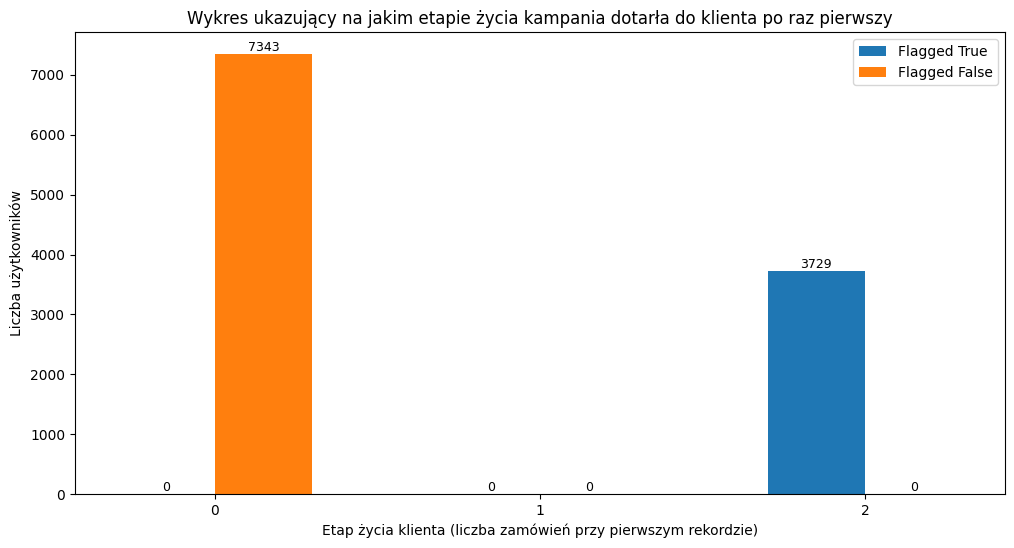

In [9]:
'''Wykres potwierdzający tezę o twierdzeniu, że kampania True była dla powracających użytkowników a False dla nowych użytkowników'''

import matplotlib.pyplot as plt
import numpy as np

# Ilość zamówień z jaką pojawił sie użytkownik
orders_per_user_true = (
    flagged_true_df
    .groupby('user_id')['lifetime_orders_so_far']
    .min()
)
orders_per_user_false = (
    flagged_false_df
    .groupby('user_id')['lifetime_orders_so_far']
    .min()
)

# Odejmujemy zamówienie, które pojawiło się w tabeli
orders_per_user_true = orders_per_user_true - 1
orders_per_user_false = orders_per_user_false - 1

# Zliczam wartości
distribution_true = orders_per_user_true.value_counts().sort_index()
distribution_false = orders_per_user_false.value_counts().sort_index()

# Tworzymy pełny zakres x (od 0 do max w obu grupach)
x = np.arange(0, max(
    orders_per_user_true.max(),
    orders_per_user_false.max()
) + 1)

# Upewniamy się, że każda kategoria będzie reprezentowana
true_counts = distribution_true.reindex(x, fill_value=0)
false_counts = distribution_false.reindex(x, fill_value=0)

bar_width = 0.3

plt.figure(figsize=(12,6))
bars_true = plt.bar(x - bar_width/2, true_counts, width=bar_width, label='Flagged True')
bars_false = plt.bar(x + bar_width/2, false_counts, width=bar_width, label='Flagged False')

# Dodanie wartości nad słupkami
for bar, height in zip(bars_true, true_counts):
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
             ha='center', va='bottom', fontsize=9)

for bar, height in zip(bars_false, false_counts):
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Etap życia klienta (liczba zamówień przy pierwszym rekordzie)')
plt.ylabel('Liczba użytkowników')
plt.title('Wykres ukazujący na jakim etapie życia kampania dotarła do klienta po raz pierwszy')
plt.xticks(x)
plt.legend()
plt.show()

In [10]:
'''Licze metryki potrzebne do zadania drugiego'''

# ---------------------------------------------Segment True-----------------------------------------
print(f'Segment oflagowany jako True\n')
# Ilość użytkowników
total_users_true = flagged_true_df['user_id'].nunique()
print(f'Ilość użytkowników:{total_users_true}')

# Ilość zamówień
total_orders_true = flagged_true_df['order_id'].nunique()
print(f'Ilość złożonych zamówień: {total_orders_true}')

# Średnia liczba zamówień (per user)
orders_per_user_true = flagged_true_df.groupby('user_id')['order_id'].count()
avg_true_orders_per_user = orders_per_user_true.mean().round(2)
print(f'Średnia ilość zamówień per user: {avg_true_orders_per_user}')

# Mediana liczby zamówień (per user) ?
median_orders_per_user_true = orders_per_user_true.median()
print(f'Mediana liczby zamówień per user: {median_orders_per_user_true}')

# Suma wszystkich sesji dla segmentu
total_flagged_true_session = flagged_true_df['sessions_before_order'].sum()

# Średnia liczba sesji (per order)
avg_flagged_true_session_per_order = flagged_true_df['sessions_before_order'].mean().round(2)
print(f'Średnia liczba sesji per order: {avg_flagged_true_session_per_order}')

# Mediana liczby sesji (per order)
median_session_before_order_true = flagged_true_df['sessions_before_order'].median().round(2)
print(f'Mediana liczby sesji per order: {median_session_before_order_true}')

# Średnia wartość pojedyńczego zamówienia (AOV)
avg_order_value_true = (total_revenue_true / total_orders_true).round(2)
print(f'Średnia wartość koszyka per order: {avg_order_value_true}')

# Mediana wartości pojedyńczego zamówienia (AOV)
median_aov_true = flagged_true_df['revenue'].median()
print(f'Mediana wartości pojedyńczego zamówienia: {median_aov_true}')

# Średnie LTV obserwowany w segmencie
ltv_per_user_true = flagged_true_df.groupby('user_id')['revenue'].sum()
avg_ltv_true = ltv_per_user_true.mean().round(2)
print(f'Średni przychód z użytkownika: {avg_ltv_true}')

# Mediana typowego użytkownika w segmencie
median_ltv_true = ltv_per_user_true.median()
print(f'Mediana przychodu użytkownika: {median_ltv_true}\n')

# ---------------------------------------------Segment False-----------------------------------------
print(f'Segment oflagowany False\n')
# Ilość zamówień dla oflagowanych użytkowników
total_flagged_false_orders = len(flagged_false_df['order_id'])

# Ilość użytkowników
total_users_false = flagged_false_df['user_id'].nunique()
print(f'Ilość użytkowników: {total_users_false}')

# Ilość zamówień dla oflagowanych użytkowników
total_orders_false = flagged_false_df['order_id'].nunique()
print(f'Ilość złożonych zamówień: {total_orders_false}')

# Średnia liczba zamówień (per user)
avg_false_orders_per_user = round((total_flagged_false_orders/ total_users_false),2)
print(f'Średnia ilość zamówień per user: {avg_false_orders_per_user}')

# Mediana liczby zamówień (per user) ?
orders_per_user_false = flagged_false_df.groupby('user_id')['order_id'].count()
median_orders_per_user_false = orders_per_user_false.median()
print(f'Mediana liczby zamówień per user: {median_orders_per_user_false}')

# Suma wszystkich sesji dla segmentu
total_flagged_false_session = flagged_false_df['sessions_before_order'].sum()

# Średnia liczba sesji (per order)
avg_flagged_false_session_per_order = flagged_false_df['sessions_before_order'].mean().round(2)
print(f'Średnia liczba sesji per order: {avg_flagged_false_session_per_order}')

# Mediana liczby sesji (per order)
median_session_before_order_false = flagged_false_df['sessions_before_order'].median().round(2)
print(f'Mediana liczby sesji per order: {median_session_before_order_false}')

# Średnia wartość pojedyńczego zamówienia (AOV)
avg_order_value_false = (total_revenue_false / total_flagged_false_orders).round(2)
print(f'Średnia wartość koszyka per order: {avg_order_value_false}')

# Mediana wartości pojedyńczego zamówienia (AOV)
median_aov_false = flagged_false_df['revenue'].median()
print(f'Mediana wartości pojedyńczego zamówienia: {median_aov_false}')

# Średnie LTV obserwowany w segmencie
ltv_per_user_false = flagged_false_df.groupby('user_id')['revenue'].sum()
avg_ltv_false = ltv_per_user_false.mean().round(2)
print(f'Średni przychód z użytkownika: {avg_ltv_false}')

# Mediana typowego użytkownika w segmencie
median_ltv_false = ltv_per_user_false.median()
print(f'Mediana przychodu użytkownika: {median_ltv_false}')

Segment oflagowany jako True

Ilość użytkowników:3729
Ilość złożonych zamówień: 8182
Średnia ilość zamówień per user: 2.19
Mediana liczby zamówień per user: 2.0
Średnia liczba sesji per order: 10.29
Mediana liczby sesji per order: 10.0
Średnia wartość koszyka per order: 45.7
Mediana wartości pojedyńczego zamówienia: 30.155
Średni przychód z użytkownika: 100.27
Mediana przychodu użytkownika: 56.06

Segment oflagowany False

Ilość użytkowników: 7343
Ilość złożonych zamówień: 17134
Średnia ilość zamówień per user: 2.33
Mediana liczby zamówień per user: 2.0
Średnia liczba sesji per order: 3.13
Mediana liczby sesji per order: 3.0
Średnia wartość koszyka per order: 46.58
Mediana wartości pojedyńczego zamówienia: 30.01
Średni przychód z użytkownika: 108.69
Mediana przychodu użytkownika: 63.86


### Tabela retencji użytkowników

In [11]:
'''Aby określić retencje dla swojego snapshotu danych tworzę własną interpretacje first_order_date. Czyli w oflagowanym df jako True określam kiedy było pierwsze zamówienie i licze ilość dni do kolejnego. Dla snapshotu 6 miesięcznego z danymi określam, że tygodniowa retencja bedzie najlepszym rozwiązaniem ze wzgledu na kompromis odnośnie dokładności danych a szumem informacyjnym'''

# ---------------------------------------------Segment True-------------------------------------------------------------------------

# Dzien pierwszego zamowienia per user (True)
first_true_order = flagged_true_df.groupby('user_id')['order_date'].min().reset_index()
first_true_order.rename(columns={'order_date':'first_order_date'}, inplace = True)

retention_true_df = flagged_true_df.merge(first_true_order, on='user_id')


# Licze ilość tygodni od pierwszego zamowienia (True)
retention_true_df['week_since_first'] = (retention_true_df['order_date'] - retention_true_df['first_order_date']).dt.days //7


#Retencja: ilu uzytkownikow pojawilo sie w danym tygodniu po pierwszym zamowienia (True)
weekly_users_count_true = retention_true_df.groupby('week_since_first')['user_id'].nunique()


# Przedstawienie procentowe (True)
weekly_retention_percent_true = (weekly_users_count_true/weekly_users_count_true.iloc[0] * 100).round(2)


# Mediana zamówień w ciągu tygodnia (True)
weekly_orders_user_true = retention_true_df.groupby(['week_since_first','user_id'])['order_id'].count().reset_index()
weekly_orders_per_user_true_median = weekly_orders_user_true.groupby('week_since_first')['order_id'].median()


# ---------------------------------------------Segment False----------------------------------------------------------------------

# Dzien pierwszego zamowienia per user (False)
first_false_order = flagged_false_df.groupby('user_id')['order_date'].min().reset_index()
first_false_order.rename(columns={'order_date':'first_order_date'}, inplace = True)

retention_false_df = flagged_false_df.merge(first_false_order, on='user_id')


# Licze ilość tygodni od pierwszego zamowienia (False)
retention_false_df['week_since_first'] = (retention_false_df['order_date'] - retention_false_df['first_order_date']).dt.days //7


#Retencja: ilu uzytkownikow pojawilo sie w danym tygodniu po pierwszym zamowienia (False)
weekly_users_count_false = retention_false_df.groupby('week_since_first')['user_id'].nunique()


# Przedstawienie procentowe (False)
weekly_retention_percent_false = (weekly_users_count_false/weekly_users_count_false.iloc[0] * 100).round(2)

# Mediana zamówień w ciągu tygodnia (True)
weekly_orders_user_false = retention_false_df.groupby(['week_since_first','user_id'])['order_id'].count().reset_index()
weekly_orders_per_user_false_median = weekly_orders_user_false.groupby('week_since_first')['order_id'].median()

# Porównanie retention userów True i False
retention_table = pd.DataFrame({
    'weekly_users_count_true': weekly_users_count_true,
    'weekly_retention_percent_true': weekly_retention_percent_true,
    'weekly_orders_per_user_true_median': weekly_orders_per_user_true_median,
    'weekly_users_count_false': weekly_users_count_false,
    'weekly_retention_percent_false': weekly_retention_percent_false,
    'weekly_orders_per_user_false_median': weekly_orders_per_user_false_median

})

retention_table.index = [f'Week {i}' for i in retention_table.index]
retention_table = retention_table.fillna(0)
retention_table['weekly_users_count_true'] = retention_table['weekly_users_count_true'].astype(int)
retention_table

,weekly_users_count_true,weekly_retention_percent_true,weekly_orders_per_user_true_median,weekly_users_count_false,weekly_retention_percent_false,weekly_orders_per_user_false_median
Week 0,3729,100.00,1.0,7343,100.00,1.0
Week 1,763,20.46,1.0,1739,23.68,1.0
Week 2,491,13.17,1.0,1249,17.01,1.0
Week 3,337,9.04,1.0,824,11.22,1.0
Week 4,230,6.17,1.0,597,8.13,1.0
Week 5,150,4.02,1.0,436,5.94,1.0
Week 6,85,2.28,1.0,288,3.92,1.0
Week 7,58,1.56,1.0,209,2.85,1.0
Week 8,42,1.13,1.0,151,2.06,1.0
Week 9,22,0.59,1.0,106,1.44,1.0


### Wykres ukazujący retencje użytkowników

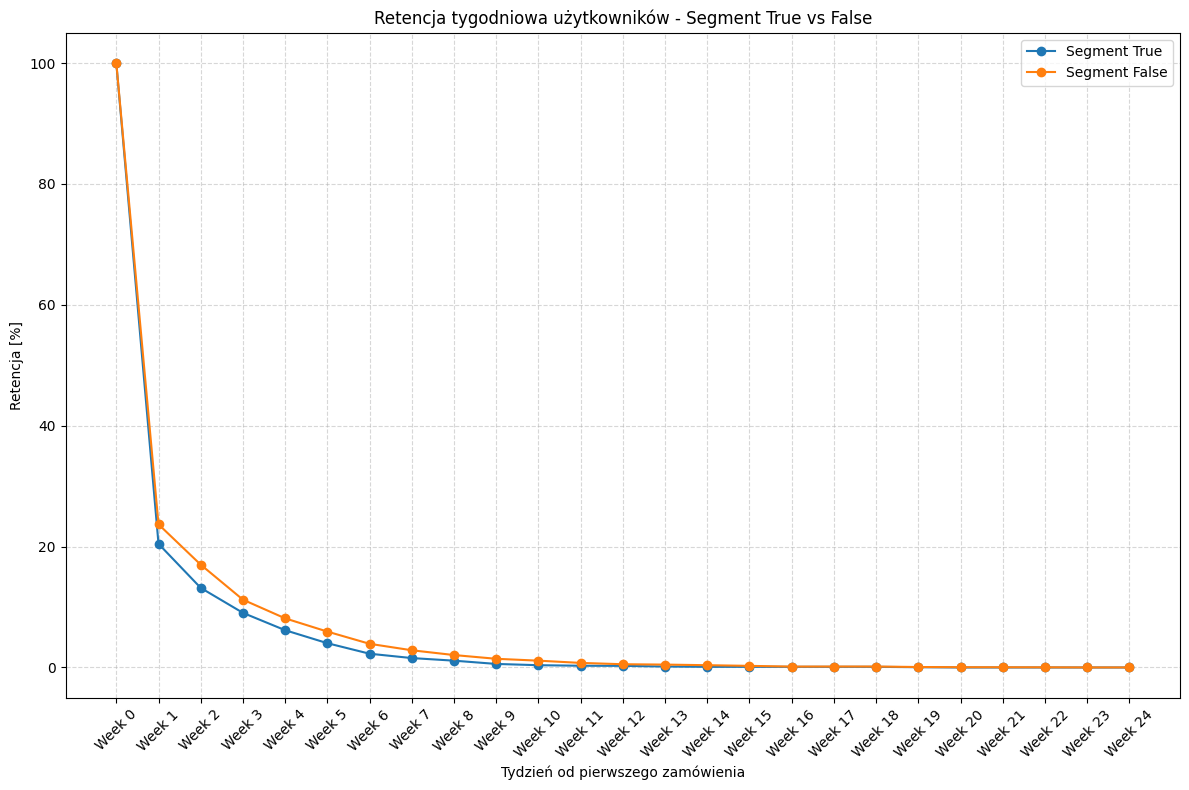

In [12]:
import matplotlib.pyplot as plt

# Dane
weeks = retention_table.index
retention_true = retention_table['weekly_retention_percent_true']
retention_false = retention_table['weekly_retention_percent_false']

# Wykres
plt.figure(figsize=(12,8))
plt.plot(weeks, retention_true, marker='o', label='Segment True')
plt.plot(weeks, retention_false, marker='o', label='Segment False')

# Opis osi
plt.xlabel('Tydzień od pierwszego zamówienia')
plt.ylabel('Retencja [%]')
plt.title('Retencja tygodniowa użytkowników - Segment True vs False')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()


plt.tight_layout()
plt.show()

### 4. Rekomendacja: Przedstaw konkretną decyzję biznesową: "Stop", "Continue" lub "Pivot" (zmiana strategii). Uzasadnij ją jedną, kluczową metryką.

Rekomendacja: **continue**. Główna metryka: mediana ROI per order.

- Segment True nie jest stratny, generuje dodatni profit i ROI jest na wysokim poziomie choć jest mniej efektywny niż segment False
- Optymalizacja kosztu marketingu może zwiększyć jego rentowność
- Segment wymaga wzmożonego monitoringu KPI, aby reagować w przypadku spadku ROI
- Kampania utrzymuje i zwiększa wartość klientów lojalnych

In [ ]:
'''Dodatkowe metryki do sprawdzenia'''

#---------------------------------------------------------Segment True------------------------------------------------

profit_df_true = flagged_true_df.copy()
profit_df_false = flagged_false_df.copy()

# Profit per user True
profit_df_true['profit'] = profit_df_true['revenue'] - profit_df_true['marketing_cost']
profit_per_user_true = profit_df_true.groupby('user_id')['profit'].sum()

# Mediana profitu per user True
median_profit_true = profit_per_user_true.median()

# ROI per user
roi_per_user_true = (profit_per_user_true / profit_df_true.groupby('user_id')['marketing_cost'].sum()) * 100

#---------------------------------------------------------Segment False-----------------------------------------------

# Profit per user False
profit_df_false['profit'] = profit_df_false['revenue'] - profit_df_false['marketing_cost']
profit_per_user_false = profit_df_false.groupby('user_id')['profit'].sum()

# Mediana profitu per user false
median_profit_false = profit_per_user_false.median()

# ROI per user
roi_per_user_false = (profit_per_user_false / profit_df_false.groupby('user_id')['marketing_cost'].sum()) * 100



print(f'Mediana profitu per user (True): {median_profit_true}')
print(f'Mediana ROI per user (True): {roi_df_per_order_true}%')
print(f'Mediana profitu per user (False): {median_profit_false}')
print(f'Mediana ROI per user (False): {roi_df_per_order_false}%')
profit_df_true['marketing_cost'].median()

Mediana profitu per user (True): 21.99
Mediana ROI per user (True): 128.49%
Mediana profitu per user (False): 40.25
Mediana ROI per user (False): 288.19%


20.0

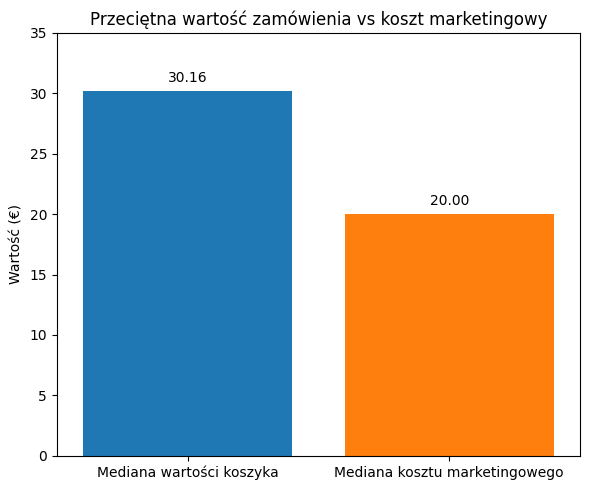

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dane
marketing_cost_median_true = flagged_true_df['marketing_cost'].median()

profit_cost_data = pd.DataFrame({
    'Metric': ['Mediana wartości koszyka', 'Mediana kosztu marketingowego'],
    'Value': [median_aov_true, marketing_cost_median_true]
})

plt.figure(figsize=(6,5))

# Ustawiam kolory żeby były spójne z porpzednimi wykresami
bars = sns.barplot(data=profit_cost_data, x='Metric', y='Value', color='lightgrey')

# Ręcznie ustawiam domyślne kolory
bars.patches[0].set_facecolor(sns.color_palette()[0])
bars.patches[1].set_facecolor(sns.color_palette()[1])

# Dodanie wartości nad słupkami
for i, row in profit_cost_data.iterrows():
    plt.text(i, row['Value'] + 0.5, f"{row['Value']:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylabel('Wartość (€)')
plt.xlabel('')
plt.ylim(0, 35)
plt.title('Przeciętna wartość zamówienia vs koszt marketingowy')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Kolejność wykonywanych kroków

In [ ]:
'''
Co robiłem faktycznie
1. Zapoznałem sie z kolumnami, wierszami i dtype
2. Zmieniam dtype order_date z object na datetime. Sprawdzam nulle, dupliakty, czy wartości w wierszach są prawidłowe.
3. Po sprawdzeniu czy duplikaty są faktycznymi duplikatami, usuwam je (100 rekordów)
4. Sprawdzam anomalie: 
  - czy znajdują się nieprawidłowe wartości gdzie nie powinny być 
  - czy istnieją fałszywe korelacje jak channel 'organic' AND marketing_cost > 0
  - czy is_new_user zawsze True AND day_since_first_order == 0
  - czy lifetime_orders_so_far < 1 AND is_new_user == False
  - czy istnieją użytkownicy jednocześnie z flagą True i False
6. Kolumna is_new_user na pierwszy rzut oka sugeruje ze zmienia się na True w momencie gdy days_since_first_order > 0. Natrafiłem na 230 rekordów gdzie sie to nie zgadzało.
7. Sprawdzam outlinery. Zapisuje kolumny o dużych wartościach, może się przyda
8. Określam grupę badawczą
9. Przystępuje do zadania 1
10. Pytania które sobie zadaje:
  - Jaki jest profit i średni profit oflagowanego segmentu jako true ?
  - Jaki jest profit i średni profit oflagowanego segmentu jako false ?
  - Jaki jest zwrot z inwestycji
11. Formuuje odpowiedź na zadane pytanie, porównując otrzymane dane
12. Przystępuje do zadania 2.
13. Zadaje sobie pytanie:
  - Ile zamówień złożyli userzy oflagowani jako True ? 
  - Czy występuja jednoczesnie jako flaga False ? Jezeli tak to powinienem złożone zamowienia doliczyć ? 
  - Sprawdzić jak dużo sesji potrzebowali do złożenia zamówienia ?
  - Jaka jest ich średnia ilość sesji na zamówienie jakie wykonują (session_before_order) ? Porównać to do tabeli false
  - Jak traktować tą anomalie z new_userami ?
  - Czy CI userzy mogą sie zwracać w czasie ?
14. Licze metryki dla true i false:
15. Po ponownym przyjrzeniu sie problemowi określenia nowego użytkownika, odkryłem, że nie jest spójna z trasakcyjnym first order. Istnieje 3729 rekordów z lifetime_orders_so_far > 1 i is_new_user = True. Oznacza to ze is_new_user moze pochodzic z innej logiki biznesowej więc ustalam nowy współczynnik nowego usera czyli lifetime_orders_so_far == 1.
16. Zajmuje sie sprawdzeniem retencji uzytkowników true i false
17. Przygotowując odpowiedzi do zadania 2, umknął mi jeden szczegół związany z grupą porównywalną. Kampanie reklamową porównałem do wszystkich flag nie uwzględniając ich pochodzenia. Najlepszą grupą porównawczą będzie również inna kampania reklamowa płatna. Poprawiłem założenie i ponownie przystąpiłem do wyciągania wniosku
18. Po wyciągnięciu wniosków z drugiego zadania sprawdzam ponownie outlinery dla segmentu True i False.
19. Wyliczenie median dla typowego uzytkownika.
20. Przystępuje do zadania 3
21. Przystępuje do zadania 4
22. Uzuepłniam metryki o mediane ROI per user i profitu per user
23. Zastanawiam się nad decyzją Continue/Pivot/Stop. Wypisuje sobie wszystkie za i przeciw dla decyzji ponieważ nie jest jednomyślna.
24. Odrzucam Stop ponieważ ROI jest wysokie i kampania przynosi profit a dowiedziałem się, że dla zarządu ROI jest kluczowa, ale nie za cenę trwałej utraty zdrowej bazy klientów.
25. Finalizuje odpowiedź do zadnia 4
26. Robie porządek w notebooku
27. Przystępuje do tworzenia wykresów
'''